In [1]:
import os
import glob

#Import data packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import Feature Extraction packages
import librosa
import librosa.display

#Import Feature Selection packages
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

#Import Model packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model

In [32]:
FEATURE_SELECTION=False # Enable for multiple features extraction and selection

## 1. Dataset
- Dataset used: RAVDESS: The RAVDESS file contains a unique filename that consists in a 7-part numerical identifier
https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data 

In [3]:
EMOTIONS={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [4]:
emotion_list = []
for file in glob.glob(os.path.join("data", "*\*.wav")):
    file_name=os.path.basename(file)
    emotion=EMOTIONS.get(file_name.split("-")[2], 'unknown')
    emotion_list.append({"emotion": emotion, "filepath": file})

In [5]:
data_df = pd.DataFrame(emotion_list)
data_df

,emotion,filepath
0,neutral,data\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,data\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,data\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,data\Actor_01\03-01-01-01-02-02-01.wav
4,calm,data\Actor_01\03-01-02-01-01-01-01.wav
...,...,...
1435,surprised,data\Actor_24\03-01-08-01-02-02-24.wav
1436,surprised,data\Actor_24\03-01-08-02-01-01-24.wav
1437,surprised,data\Actor_24\03-01-08-02-01-02-24.wav
1438,surprised,data\Actor_24\03-01-08-02-02-01-24.wav


In [6]:
data_df.groupby(['emotion']).size()

emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
dtype: int64

## 2. Feature Extraction
- Techniques Used: <b>1. MFCC   2. STFT</b>
- Package Used: <b>Librosa</b>

#### 1. MFCC Feature extraction

In [7]:
n_mfcc = 40

In [8]:
def extract_mfcc(audio_file_path):
    audio_signal, sampling_rate = librosa.load(audio_file_path)
    mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=n_mfcc)
    mfcc_mean = mfcc.mean(axis=1)
    return pd.Series(mfcc_mean, name='mfcc')

mfcc_feature_df = data_df['filepath'].apply(extract_mfcc)
mfcc_feature_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-697.792603,54.890041,0.663465,12.435786,7.733951,0.530750,-3.216631,-3.159394,-10.977551,-2.848711,...,-2.035756,-2.119634,-2.712589,-1.836127,-3.204805,-1.545368,-1.090937,-1.770106,-3.501132,-1.538087
1,-692.855774,55.363899,-1.548319,16.038307,8.818810,-0.146586,-1.373392,-5.293180,-11.623182,-1.348284,...,-1.456313,-2.677299,-2.143264,-2.461078,-3.019027,-0.804861,-1.290269,-3.086972,-3.209748,-2.307159
2,-691.587891,58.024662,0.159464,13.624650,5.374112,1.162336,-2.083360,-5.382585,-10.332824,-3.662081,...,-1.807128,-2.134344,-2.395042,-1.902937,-2.764431,-1.979177,-1.104503,-2.729537,-3.508906,-2.246375
3,-685.105469,55.879421,2.783262,13.252024,6.989670,2.981274,-1.586029,-6.961661,-10.348489,-3.270769,...,-2.439686,-2.166375,-2.881300,-2.769905,-3.236377,-1.457207,-0.953106,-2.450082,-3.419579,-3.367244
4,-727.104370,62.355034,3.121181,15.064671,8.132434,1.927084,-3.274656,-3.761792,-9.750299,-4.853837,...,-2.091125,-1.200895,-1.910600,-2.423685,-1.769384,-0.418556,-1.791783,-1.721066,-3.857927,-2.711537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-586.506653,24.936184,-17.393667,-1.750550,-15.307642,-9.822910,-15.646088,-15.538772,-6.393435,-7.308449,...,-1.312277,0.841299,1.208772,0.867226,-1.585376,-1.422547,-1.799555,-0.350891,-0.976825,0.346321
1436,-532.467224,37.716988,-14.932145,-5.954791,-15.144545,-13.899151,-10.687799,-12.034179,-8.265898,-3.624761,...,-1.497369,-0.268410,-0.695980,0.125675,-0.713901,1.149953,-1.927502,-1.126146,-1.219409,-0.265920
1437,-541.251648,29.595709,-18.001362,-3.139160,-14.282516,-17.555689,-12.232482,-12.344251,-6.859198,-0.788208,...,0.644287,1.022761,-1.067139,-0.112777,-0.932430,0.871134,-1.150174,-0.389067,-0.971947,-0.003921
1438,-492.652527,23.887981,-6.026659,1.677622,-11.062459,-5.152931,-10.083343,-9.132249,-1.253074,-4.533324,...,-0.885057,0.890772,-1.782649,-0.206613,-1.027395,0.909119,0.286293,0.916377,-1.432690,1.430012


#### 2. STFT Feature extraction

In [9]:
def extract_stft(audio_file_path):
    audio_signal, sampling_rate = librosa.load(audio_file_path)
    stft = librosa.stft(audio_signal)
    stft_mag, _ = librosa.magphase(stft)  # Get magnitude spectrogram
    stft_mean = stft_mag.mean(axis=1)  # Compute mean along the time axis
    return pd.Series(stft_mean, name='stft')

if FEATURE_SELECTION:
    stft_feature_df = data_df['filepath'].apply(extract_stft)
    stft_feature_df

#### Combine all Features

In [10]:
if FEATURE_SELECTION:
    features_df =  pd.concat([mfcc_feature_df, stft_feature_df], axis=1)
else:
    features_df = mfcc_feature_df
features_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-697.792603,54.890041,0.663465,12.435786,7.733951,0.530750,-3.216631,-3.159394,-10.977551,-2.848711,...,-2.035756,-2.119634,-2.712589,-1.836127,-3.204805,-1.545368,-1.090937,-1.770106,-3.501132,-1.538087
1,-692.855774,55.363899,-1.548319,16.038307,8.818810,-0.146586,-1.373392,-5.293180,-11.623182,-1.348284,...,-1.456313,-2.677299,-2.143264,-2.461078,-3.019027,-0.804861,-1.290269,-3.086972,-3.209748,-2.307159
2,-691.587891,58.024662,0.159464,13.624650,5.374112,1.162336,-2.083360,-5.382585,-10.332824,-3.662081,...,-1.807128,-2.134344,-2.395042,-1.902937,-2.764431,-1.979177,-1.104503,-2.729537,-3.508906,-2.246375
3,-685.105469,55.879421,2.783262,13.252024,6.989670,2.981274,-1.586029,-6.961661,-10.348489,-3.270769,...,-2.439686,-2.166375,-2.881300,-2.769905,-3.236377,-1.457207,-0.953106,-2.450082,-3.419579,-3.367244
4,-727.104370,62.355034,3.121181,15.064671,8.132434,1.927084,-3.274656,-3.761792,-9.750299,-4.853837,...,-2.091125,-1.200895,-1.910600,-2.423685,-1.769384,-0.418556,-1.791783,-1.721066,-3.857927,-2.711537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-586.506653,24.936184,-17.393667,-1.750550,-15.307642,-9.822910,-15.646088,-15.538772,-6.393435,-7.308449,...,-1.312277,0.841299,1.208772,0.867226,-1.585376,-1.422547,-1.799555,-0.350891,-0.976825,0.346321
1436,-532.467224,37.716988,-14.932145,-5.954791,-15.144545,-13.899151,-10.687799,-12.034179,-8.265898,-3.624761,...,-1.497369,-0.268410,-0.695980,0.125675,-0.713901,1.149953,-1.927502,-1.126146,-1.219409,-0.265920
1437,-541.251648,29.595709,-18.001362,-3.139160,-14.282516,-17.555689,-12.232482,-12.344251,-6.859198,-0.788208,...,0.644287,1.022761,-1.067139,-0.112777,-0.932430,0.871134,-1.150174,-0.389067,-0.971947,-0.003921
1438,-492.652527,23.887981,-6.026659,1.677622,-11.062459,-5.152931,-10.083343,-9.132249,-1.253074,-4.533324,...,-0.885057,0.890772,-1.782649,-0.206613,-1.027395,0.909119,0.286293,0.916377,-1.432690,1.430012


## 3. Feature Selection
- Techniques Used: <b>RFE</b>
- Model Used: <b>RandomForestClassifier</b>
- Package Used: <b>Librosa</b>

In [11]:
if FEATURE_SELECTION:
    n_features_to_select = 10 # Select top 10 features
    n_pca = 10

In [12]:
# Encode target dataframe
if FEATURE_SELECTION:
    target_df = data_df['emotion']
    label_encoder = LabelEncoder()
    target_df_encoded = label_encoder.fit_transform(target_df)
    target_df_encoded

#### Principal Component Analysis (PCA) for dimensionality reduction

In [13]:
if FEATURE_SELECTION:
    pca = PCA(n_components=n_pca)
    features_df_pca = pca.fit_transform(features_df)
    features_df_pca

#### Apply RFE to Select the Features

In [14]:
if FEATURE_SELECTION:
    # RFE
    classifier = RandomForestClassifier()
    rfe = RFE(estimator=classifier, n_features_to_select=n_features_to_select)
    rfe.fit(features_df_pca, target_df_encoded)
    
    # Selected Features
    selected_indices = rfe.get_support(indices=True)
    selected_features = features_df.columns[selected_indices]
    
    # Filterout selected features
    final_data_df = features_df[selected_features].copy()
else:
    final_data_df = mfcc_feature_df
final_data_df['emotion'] = data_df['emotion']
final_data_df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-697.792603,54.890041,0.663465,12.435786,7.733951,0.530750,-3.216631,-3.159394,-10.977551,-2.848711,...,-2.119634,-2.712589,-1.836127,-3.204805,-1.545368,-1.090937,-1.770106,-3.501132,-1.538087,neutral
1,-692.855774,55.363899,-1.548319,16.038307,8.818810,-0.146586,-1.373392,-5.293180,-11.623182,-1.348284,...,-2.677299,-2.143264,-2.461078,-3.019027,-0.804861,-1.290269,-3.086972,-3.209748,-2.307159,neutral
2,-691.587891,58.024662,0.159464,13.624650,5.374112,1.162336,-2.083360,-5.382585,-10.332824,-3.662081,...,-2.134344,-2.395042,-1.902937,-2.764431,-1.979177,-1.104503,-2.729537,-3.508906,-2.246375,neutral
3,-685.105469,55.879421,2.783262,13.252024,6.989670,2.981274,-1.586029,-6.961661,-10.348489,-3.270769,...,-2.166375,-2.881300,-2.769905,-3.236377,-1.457207,-0.953106,-2.450082,-3.419579,-3.367244,neutral
4,-727.104370,62.355034,3.121181,15.064671,8.132434,1.927084,-3.274656,-3.761792,-9.750299,-4.853837,...,-1.200895,-1.910600,-2.423685,-1.769384,-0.418556,-1.791783,-1.721066,-3.857927,-2.711537,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-586.506653,24.936184,-17.393667,-1.750550,-15.307642,-9.822910,-15.646088,-15.538772,-6.393435,-7.308449,...,0.841299,1.208772,0.867226,-1.585376,-1.422547,-1.799555,-0.350891,-0.976825,0.346321,surprised
1436,-532.467224,37.716988,-14.932145,-5.954791,-15.144545,-13.899151,-10.687799,-12.034179,-8.265898,-3.624761,...,-0.268410,-0.695980,0.125675,-0.713901,1.149953,-1.927502,-1.126146,-1.219409,-0.265920,surprised
1437,-541.251648,29.595709,-18.001362,-3.139160,-14.282516,-17.555689,-12.232482,-12.344251,-6.859198,-0.788208,...,1.022761,-1.067139,-0.112777,-0.932430,0.871134,-1.150174,-0.389067,-0.971947,-0.003921,surprised
1438,-492.652527,23.887981,-6.026659,1.677622,-11.062459,-5.152931,-10.083343,-9.132249,-1.253074,-4.533324,...,0.890772,-1.782649,-0.206613,-1.027395,0.909119,0.286293,0.916377,-1.432690,1.430012,surprised


## 4. Model Selection and Training
- Model Used: <b>Random Forest, SVM, LSTM, and CNN </b>
- Model Selection, Optimiser: <b>Train Test Split, Adam</b>

#### Split Train and Test data

In [15]:
x_train, x_test, y_train, y_test = train_test_split(final_data_df.drop(columns=['emotion']),
                                                    final_data_df['emotion'], test_size=0.2, random_state=42)
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (1152, 40)
y_train shape: (1152,)
x_test shape: (288, 40)
y_test shape: (288,)


### Random Forest

In [16]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy*100} %")

Random Forest Model Accuracy: 60.416666666666664 %


### SVC

In [17]:
svc_model = SVC()
svc_model.fit(x_train, y_train)
y_pred = svc_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVC Model Accuracy: {accuracy*100} %")

SVC Model Accuracy: 30.555555555555557 %


### KNN

In [18]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy: {accuracy*100} %")

KNN Model Accuracy: 48.26388888888889 %


### Gradient Boosting

In [19]:
gbc_model = GradientBoostingClassifier()
gbc_model.fit(x_train, y_train)
y_pred = gbc_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Model Accuracy: {accuracy*100} %")

Gradient Boosting Model Accuracy: 54.513888888888886 %


### CNN (Convolution Neural Network)

#### Change Dimensions for CNN

In [20]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)
print(x_traincnn.shape)
print(x_testcnn.shape)

(1152, 40, 1)
(288, 40, 1)


#### Build CNN Model

In [34]:
cnn_model = Sequential()

# Add First layer
cnn_model.add(Conv1D(16, 5, padding='same', input_shape=(40, 1), activation='relu'))

# Add Second layer
cnn_model.add(Conv1D(32, 5, padding='same', activation='relu'))

# Add Third layer
cnn_model.add(Conv1D(64, 5, padding='same', activation='relu'))

# Add Fourth layer
cnn_model.add(Conv1D(128, 5, padding='same', activation='relu'))
    
# Add Dropout
cnn_model.add(Dropout(0.1))

# Flatten 
cnn_model.add(Flatten(input_shape=(40, 1)))  # Specify input shape explicitly

# Add Dense layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(8, activation='softmax'))

# Print model summary
cnn_model.summary()

d:\nikh\learning\mca\codebase\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\nikh\learning\mca\codebase\env\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 40, 16)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 40, 32)              │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 40, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 40, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         655,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 718,344 (2.74 MB)

 Trainable params: 718,344 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile CNN model with loss function, optimizer, and accuracy metric to optimize

In [35]:
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

#### Encode emotion labels into numbers

In [36]:
lb = LabelEncoder()
y_train_lb = to_categorical(lb.fit_transform(y_train))
y_test_lb = to_categorical(lb.fit_transform(y_test))

#### Encoding labels

In [37]:
labels_encoded = {}
for i, label in enumerate(lb.classes_):
    labels_encoded[i] = label
labels_encoded

{0: 'angry',
 1: 'calm',
 2: 'disgust',
 3: 'fearful',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprised'}

#### CNN Model Fitting

In [38]:
cnn_results = cnn_model.fit(x_traincnn, y_train_lb,
                             batch_size=64,
                             epochs=25,
                             verbose=1,
                             validation_data=(x_testcnn, y_test_lb))

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.1304 - loss: 2.8580 - val_accuracy: 0.1840 - val_loss: 2.0142
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2105 - loss: 1.9877 - val_accuracy: 0.2812 - val_loss: 1.9067
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2386 - loss: 1.9291 - val_accuracy: 0.2674 - val_loss: 1.8514
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2890 - loss: 1.8390 - val_accuracy: 0.3021 - val_loss: 1.7908
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3269 - loss: 1.7449 - val_accuracy: 0.3646 - val_loss: 1.7435
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3646 - loss: 1.6948 - val_accuracy: 0.3785 - val_loss: 1.6239
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4057 - loss: 1.5649 - val_accuracy: 0.4306 - val_loss: 1.5430
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4469 - loss: 1.4934 - val_accuracy: 0.4201 - v

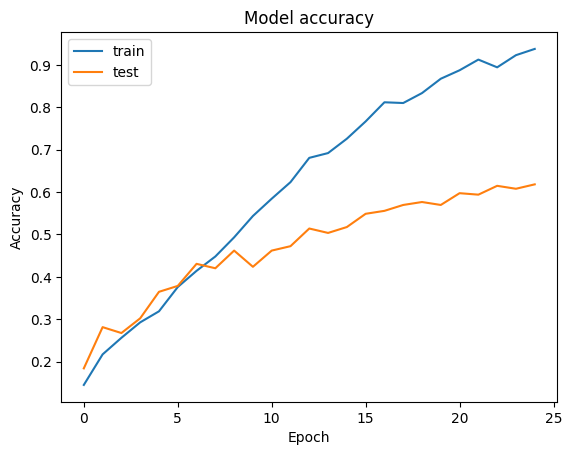

In [39]:
#Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# Evaluating the model on the training and testing set
score = cnn_model.evaluate(x_traincnn, y_train_lb, verbose=0)
print(f"Training Accuracy: {score[1]*100} %")

score = cnn_model.evaluate(x_testcnn, y_test_lb, verbose=0)
print(f"Testing Accuracy: {score[1]*100} %")

Training Accuracy: 98.17708134651184 %
Testing Accuracy: 61.80555820465088 %


#### Model Predictions

In [41]:
y_test_probabilities = cnn_model.predict(x_testcnn)
y_test_predictions = np.argmax(y_test_probabilities, axis=1)
y_test_predictions

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([1, 1, 3, 1, 2, 1, 1, 3, 3, 1, 0, 7, 6, 4, 1, 2, 2, 3, 1, 4, 4, 2,
       1, 1, 3, 6, 3, 7, 2, 6, 4, 0, 3, 5, 1, 1, 2, 0, 3, 0, 1, 5, 1, 0,
       2, 1, 1, 5, 3, 4, 2, 3, 7, 2, 1, 2, 1, 7, 2, 6, 7, 3, 7, 2, 3, 0,
       1, 2, 5, 6, 7, 2, 1, 4, 2, 4, 0, 7, 1, 2, 4, 4, 7, 1, 4, 0, 3, 1,
       6, 1, 5, 1, 0, 2, 1, 2, 7, 4, 7, 7, 2, 3, 2, 2, 5, 4, 1, 2, 3, 5,
       7, 0, 7, 4, 2, 0, 3, 2, 2, 3, 2, 1, 7, 3, 6, 0, 7, 2, 3, 3, 4, 4,
       1, 3, 1, 6, 6, 1, 2, 2, 2, 5, 4, 3, 0, 6, 4, 1, 5, 3, 3, 4, 1, 3,
       4, 1, 7, 6, 7, 3, 6, 4, 0, 1, 1, 5, 0, 1, 3, 7, 1, 3, 0, 2, 3, 1,
       7, 7, 4, 2, 4, 3, 4, 1, 5, 6, 7, 0, 0, 3, 1, 3, 2, 1, 3, 3, 7, 7,
       2, 1, 3, 6, 6, 6, 1, 0, 2, 1, 4, 7, 7, 4, 7, 3, 1, 2, 0, 3, 7, 4,
       4, 4, 1, 6, 6, 2, 1, 2, 6, 5, 6, 7, 6, 7, 7, 2, 2, 0, 0, 1, 2, 5,
       7, 5, 7, 3, 5, 1, 1, 6, 3, 6, 2, 1, 0, 2, 6, 7, 1, 1, 1, 1, 1, 5,
       4, 1, 2, 4, 7, 1, 2, 1, 6, 2, 7, 2, 0, 5, 3, 2, 0, 4, 6, 2, 6, 0,
       2, 6], dtype=int64)

In [42]:
def get_labled_predictions(labels_encoded, test_predictions):
    return [labels_encoded[test_predictions[t]] for t in range(len(test_predictions))]

print(get_labled_predictions(labels_encoded, y_test_predictions))

['calm', 'calm', 'fearful', 'calm', 'disgust', 'calm', 'calm', 'fearful', 'fearful', 'calm', 'angry', 'surprised', 'sad', 'happy', 'calm', 'disgust', 'disgust', 'fearful', 'calm', 'happy', 'happy', 'disgust', 'calm', 'calm', 'fearful', 'sad', 'fearful', 'surprised', 'disgust', 'sad', 'happy', 'angry', 'fearful', 'neutral', 'calm', 'calm', 'disgust', 'angry', 'fearful', 'angry', 'calm', 'neutral', 'calm', 'angry', 'disgust', 'calm', 'calm', 'neutral', 'fearful', 'happy', 'disgust', 'fearful', 'surprised', 'disgust', 'calm', 'disgust', 'calm', 'surprised', 'disgust', 'sad', 'surprised', 'fearful', 'surprised', 'disgust', 'fearful', 'angry', 'calm', 'disgust', 'neutral', 'sad', 'surprised', 'disgust', 'calm', 'happy', 'disgust', 'happy', 'angry', 'surprised', 'calm', 'disgust', 'happy', 'happy', 'surprised', 'calm', 'happy', 'angry', 'fearful', 'calm', 'sad', 'calm', 'neutral', 'calm', 'angry', 'disgust', 'calm', 'disgust', 'surprised', 'happy', 'surprised', 'surprised', 'disgust', 'fearf

# Custom Speech Input Emotion Predection

In [43]:
def get_labled_predictions(labels_encoded, test_predictions):
    return [labels_encoded[test_predictions[t]] for t in range(len(test_predictions))]
    
def cnn_model_prediction(model, file_path, labels_encoded):
    # Load the audio file
    audio_signal, sampling_rate = librosa.load(file_path)
    
    # Perform feature extraction
    mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=n_mfcc)
    
    # Normalize the MFCC features
    normalized_mfcc = np.mean(mfcc.T, axis=0)

    # Add batch and channel dimensions
    input_data = np.expand_dims(normalized_mfcc, axis=0)  # Add batch dimension
    input_data = np.expand_dims(input_data, axis=-1) 
    
    # Predict
    custom_prob = model.predict(input_data)
    custom_predictions = np.argmax(custom_prob, axis=1)
    return get_labled_predictions(labels_encoded, custom_predictions)

def model_prediction(model, file_path):
    # Load the audio file
    audio_signal, sampling_rate = librosa.load(file_path)
    
    # Perform feature extraction
    mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=n_mfcc)
    
    # Normalize the MFCC features
    normalized_mfcc = np.mean(mfcc.T, axis=0)
    
    # Reshape the input for the model
    input_data = np.expand_dims(normalized_mfcc, axis=0)

    # Predict
    custom_predictions = model.predict(input_data)
    return custom_predictions.tolist()

#### Save the CNN model

In [67]:
from keras.models import model_from_json

def save_model():
    # serialize model to json
    json_model = cnn_model.to_json()
    # save the model architecture to JSON file
    with open('SpeechEmotionCNNModel.json', 'w') as json_file:
        json_file.write(json_model)
    # saving the weights of the model
    cnn_model.save_weights('SpeechEmotionCNNModel.weights.h5')
    # Model loss and accuracy
    print("Saved model to disk")

save_model()

Saved model to disk


#### Load the model

In [68]:
def load_model():
    json_file = open('SpeechEmotionCNNModel.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("SpeechEmotionCNNModel.weights.h5")
    print("Loaded model from disk")
    return loaded_model

loaded_cnn_model = load_model()

Loaded model from disk


In [69]:
run_models = [loaded_cnn_model]
for custom_fp in glob.glob(os.path.join("data", "custom", "*.mp3")):
    print(f"--------------- {custom_fp} ---------------------")
    for run_model in run_models:
        model_name = run_model.__class__.__name__
        if model_name == 'Sequential':
            prediction = cnn_model_prediction(run_model, custom_fp, labels_encoded)
        else:
            prediction = model_prediction(run_model, custom_fp)
        print(f"{model_name:40} ==> {prediction[0]}")

--------------- data\custom\Calm-about_anger.mp3 ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Sequential                               ==> calm
--------------- data\custom\calm-dad-says-bye-bye-113119.mp3 ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sequential                               ==> calm
--------------- data\custom\calm-time-erase-the-pain-i-feel.mp3 ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sequential                               ==> happy
--------------- data\custom\disgust-child-says-yes.mp3 ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sequential                               ==> disgust
--------------- data\custom\Fear-Angry-slightly-strange.mp3 ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sequential                               ==> calm
--------------- data\custom\fear-had-enough-spoken.mp3 ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sequential                               